In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import seaborn as sns

import skimage as skimage
import scipy as scipy
import scipy.ndimage
import cv2 as cv

import time

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 12})

In [2]:
Testing_Mode = False

In [3]:
def Test_Image():
    
    from skimage.draw import circle_perimeter_aa

    raw_image = np.zeros((600, 600)).astype(np.float32)

    rr, cc, val = circle_perimeter_aa(150, 150, 100)
    raw_image[rr, cc] = val

    rr, cc, val = circle_perimeter_aa(350, 300, 50)
    raw_image[rr, cc] = val

    raw_image = raw_image * 255
    
    return raw_image


if Testing_Mode == False:
    
    filename = 'H70T_10.tif'
    
    raw_image = skimage.io.imread(filename).astype('float32')

if Testing_Mode == True:

    raw_image = Test_Image()

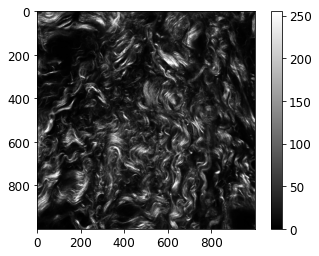

In [4]:
plt.imshow(raw_image, cmap = 'binary_r')

plt.colorbar()

In [5]:
image_filter_sigma = 1

local_window_size = 20 # pixels

threshold_value = max(int(0.5 * np.median(raw_image)), 2)

########################################################################

spacing = 30 # Spacing between plotting the orientation vectors

scale = 50 # Length of each vector for plotting

In [6]:
def make_binary_image(input_image):

    threshold_value = skimage.filters.threshold_otsu(input_image)

    binary_image = input_image > threshold_value
    
    return binary_image

In [7]:
def make_image_same_shape(image):

    raw_image = np.zeros((max(image.shape), max(image.shape)))

    raw_image[:len(image)] = image
    
    return raw_image

In [8]:
def make_HeatMap(input_image, number_heatmap_windows):
    
    number_heatmap_windows = 20

    # Define the local ROI

    local_region = skimage.morphology.square(max(int(min(input_image.shape) / number_heatmap_windows), 1))

    heatmap_image = skimage.filters.rank.mean(skimage.util.img_as_ubyte(input_image / input_image.max()), 
                                              footprint = local_region)
    
    #########################################################################################################

#     local_region = skimage.morphology.square(max(int(min(input_image.shape) / number_heatmap_windows), 1))

#     filtered_image = skimage.filters.median(input_image)

#     binarized_image = filtered_image > (skimage.filters.threshold_otsu(filtered_image))

#     heatmap_image = skimage.filters.rank.mean(binarized_image.astype(np.uint8), footprint = local_region)
    
    return heatmap_image

In [9]:
def make_StructureTensor2D(input_image, image_filter_sigma, local_window_size):

    ### Calculate image gradients using Sobel filters

    #########################################################################################################
    
    ### Filter the image a bit

    filtered_image = skimage.filters.gaussian(input_image, sigma = image_filter_sigma, mode = 'nearest')
    
    ### Calculate image gradients in x and y directions

    image_gradient_x = scipy.ndimage.sobel(filtered_image, axis = 0, mode = 'nearest')

    image_gradient_y = scipy.ndimage.sobel(filtered_image, axis = 1, mode = 'nearest')

    #########################################################################################################

    ### Calculate Jxx, Jyy and Jxy

    Jxx = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_x, 
                                        local_window_size, mode = 'nearest')

    Jyy = scipy.ndimage.gaussian_filter(image_gradient_y * image_gradient_y, 
                                        local_window_size, mode = 'nearest')

    Jxy = scipy.ndimage.gaussian_filter(image_gradient_x * image_gradient_y, 
                                        local_window_size, mode = 'nearest')

    #########################################################################################################

    ### Make Structure Tensor

    Raw_Structure_Tensor = np.array([[Jxx, Jxy], 
                                     [Jxy, Jyy]])

    Structure_Tensor = np.moveaxis(Raw_Structure_Tensor, [0, 1], [2, 3]) # For solving EigenProblem
    
#     Energy = np.trace(Raw_Structure_Tensor)

    EigenValues, EigenVectors = np.linalg.eigh(Structure_Tensor) # eigh because matrix is symmetric
    
    return Structure_Tensor, EigenValues, EigenVectors, Jxx, Jxy, Jyy

In [10]:
def make_Coherance_Orientation(input_image, EigenValues, EigenVectors, Structure_Tensor, Jxx, Jxy, Jyy):
    
    vx = EigenVectors[..., 0][:, :, 0]
    vx[input_image < threshold_value] = np.nan

    vy = EigenVectors[..., 0][:, :, 1]
    vy[input_image < threshold_value] = np.nan
    
    #############################################
    
    Orientation = 0.5 * ( cv.phase( (Jyy - Jxx), (2 * Jxy), 
                                   angleInDegrees = True) )

    Orientation[input_image < threshold_value] = np.nan
    
    #############################################

    Coherance = np.zeros(input_image.shape)
    
    for j in range(input_image.shape[1]):

        for i in range(input_image.shape[0]):

            if ( ( (EigenValues[i, j].sum()) > 0) and (input_image[i, j] > threshold_value)):

                Smallest_Normalized_Eigenvalues = EigenValues[i, j][0] / np.trace(Structure_Tensor[i, j])

                Largest_Normalized_Eigenvalues = EigenValues[i, j][1] / np.trace(Structure_Tensor[i, j])

                Coherance[i, j] = np.abs((Largest_Normalized_Eigenvalues - Smallest_Normalized_Eigenvalues) /
                                         (Smallest_Normalized_Eigenvalues + Largest_Normalized_Eigenvalues))

            else:

                Coherance[i, j] = np.nan

    return Coherance, Orientation, vx, vy

In [11]:
def discrete_cmap(N, base_cmap):
    
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    
    color_list = base(np.linspace(0, 1, N))
    
    cmap_name = base.name + str(N)
    
    return base.from_list(cmap_name, color_list, N)

### Start the analysis

In [12]:
start = time.time()

Structure_Tensor, EigenValues, EigenVectors, Jxx, Jxy, Jyy = make_StructureTensor2D(raw_image, 
                                                                                    image_filter_sigma, 
                                                                                    local_window_size)

In [13]:
Coherance, Orientation, vx, vy = make_Coherance_Orientation(raw_image, 
                                                            EigenValues, EigenVectors, 
                                                            Structure_Tensor, Jxx, Jxy, Jyy)

end = time.time()

##########################################################################################

print('Coherance and Orientation calculations took ' + str(int(end - start)) + ' seconds')

print()

Coherance and Orientation calculations took 8 seconds



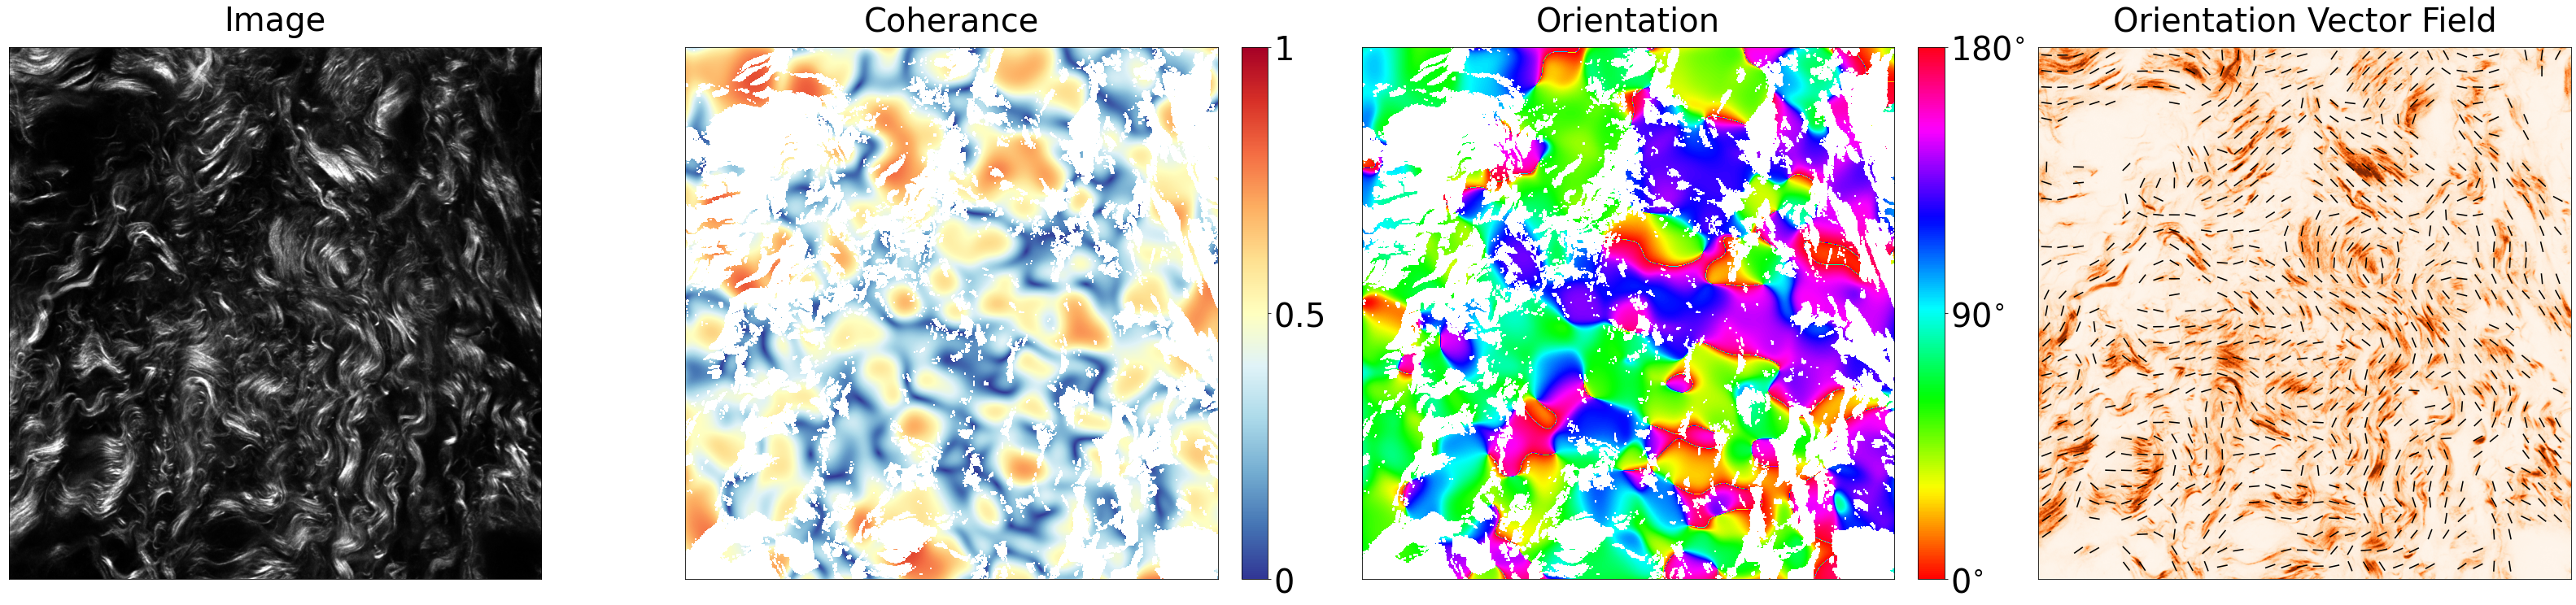

In [14]:
fig, ax = plt.subplots(1, 4, figsize = (45, 15), sharex = True, sharey = True)

ax[0].imshow(raw_image,cmap = 'binary_r')

ax[0].set_title('Image', pad = 20, fontsize = 40)
ax[0].set_xticks([])
ax[0].set_yticks([])

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.4)
cax0.remove()

########################################################################

im1 = ax[1].imshow(Coherance, vmin = 0, vmax = 1, cmap = 'RdYlBu_r')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad = 0.4)
# cbar = fig.colorbar(im1, cax = cax, ticks = np.linspace(0, 1, 5))
# cbar.ax.set_yticklabels([r'$0$', r'$0.25$', r'$0.5$', r'$0.75$', r'$1$'], fontsize = 40)
cbar = fig.colorbar(im1, cax = cax, ticks = np.linspace(0, 1, 3))
cbar.ax.set_yticklabels([r'$0$', r'$0.5$', r'$1$'], fontsize = 40)

ax[1].set_title('Coherance', pad = 20, fontsize = 40)
ax[1].set_xticks([])
ax[1].set_yticks([])

###########################################################data#############

im2 = ax[2].imshow(Orientation/180, vmin = 0, vmax = 1, cmap = 'hsv')

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.4)
cbar = fig.colorbar(im2, cax = cax, ticks = np.linspace(0, 1, 3))
cbar.ax.set_yticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'], fontsize = 40)

ax[2].set_title('Orientation', pad = 20, fontsize = 40)
ax[2].set_xticks([])
ax[2].set_yticks([])

########################################################################

im3 = ax[3].imshow(raw_image, cmap = 'Oranges', alpha = 1)

xmesh, ymesh = np.meshgrid(np.arange(raw_image.shape[0]), 
                           np.arange(raw_image.shape[1]), 
                           indexing = 'ij')

ax[3].quiver(ymesh[spacing//2::spacing, spacing//2::spacing], xmesh[spacing//2::spacing, spacing//2::spacing],
             vy[spacing//2::spacing, spacing//2::spacing], vx[spacing//2::spacing, spacing//2::spacing],
             scale = scale, headlength = 0, headaxislength = 0, 
             pivot = 'middle', color = 'k', angles = 'xy')

ax[3].set_title('Orientation Vector Field', pad = 20, fontsize = 40)
ax[3].set_xticks([])
ax[3].set_yticks([])

divider = make_axes_locatable(ax[3])
cax = divider.append_axes("right", size="5%", pad=0.4)
cax.remove()

########################################################################

fig.tight_layout()

# image_string = 'Result_' + 'W_' + str(local_window_size) + ',' + filename

# size = len(image_string)

# image_string = image_string[:size - 4] + '.pdf'

# plt.savefig(image_string)

# plt.close()

### Save the arrays

In [15]:
fname = 'Structure_Tensor_' + 'W_' + str(local_window_size) + ',' + filename

size = len(fname)

fname = fname[:size - 4] + '.npy'

# np.save(fname, Structure_Tensor)

########################################################################

fname = 'EigenValues_' + 'W_' + str(local_window_size) + ',' + filename

size = len(fname)

fname = fname[:size - 4] + '.npy'

# np.save(fname, EigenValues)

########################################################################

fname = 'EigenVectors_' + 'W_' + str(local_window_size) + ',' + filename

size = len(fname)

fname = fname[:size - 4] + '.npy'

# np.save(fname, EigenVectors)

########################################################################

fname = 'Orientation_' + 'W_' + str(local_window_size) + ',' + filename

size = len(fname)

fname = fname[:size - 4] + '.npy'

# np.save(fname, Orientation)

########################################################################

fname = 'Coherance_' + 'W_' + str(local_window_size) + ',' + filename

size = len(fname)

fname = fname[:size - 4] + '.npy'

# np.save(fname, Coherance)

########################################################################

results_array = np.hstack((image_filter_sigma, 
                           local_window_size, threshold_value, 
                           np.nanmean(Orientation), np.nanmedian(Orientation), np.nanstd(Orientation), 
                           np.nanmean(Coherance), np.nanmedian(Coherance), np.nanstd(Coherance)))

fname = 'Result_' + 'W_' + str(local_window_size) + ',' + filename

size = len(fname)

fname = fname[:size - 4] + '.txt'

# np.savetxt(fname, results_array, fmt = '%0.2f')